In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F

cuda
[Epoch 10] loss: 0.012
[Epoch 20] loss: 0.007
[Epoch 30] loss: 0.018
[Epoch 40] loss: 0.003
[Epoch 50] loss: 0.001


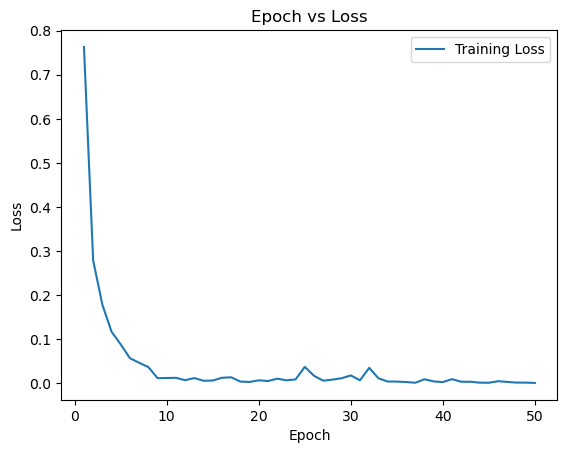

Finished Training


In [41]:
# Define transformation for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load custom dataset using ImageFolder
full_dataset = datasets.ImageFolder(root='/scratch/anair66/sml_dataset', transform=transform)

# Split dataset into training and testing subsets (80-20 split)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Define data loaders for training and testing
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Check if GPU is available, otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load pre-trained ConvNet_Tiny model and move it to GPU
model = models.convnext_tiny(weights='IMAGENET1K_V1').to(device)
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(train_dataset.dataset.classes)).to(device)  # Adjust output size according to your dataset

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
epochs = 50
# Initialize an empty list to store the loss values
losses = []

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move inputs and labels to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Store the average loss for this epoch
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    # Print loss after every 10 epochs
    if (epoch + 1) % 10 == 0:
        print('[Epoch %d] loss: %.3f' % (epoch + 1, epoch_loss))

# Plot the epoch vs loss curve
plt.plot(range(1, epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

print('Finished Training')
torch.save(model,'smlconvnext_classification.pth')

Accuracy on test set: 94 %


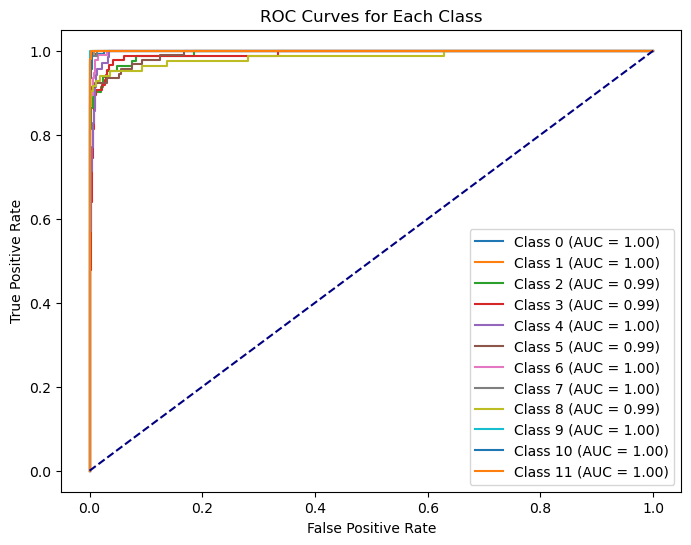

In [43]:
# Evaluate the model on the test set
correct = 0
total = 0
predicted_probs = []
true_labels = []
num_classes = 12
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)  # Move inputs and labels to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = F.softmax(outputs, dim=1).cpu().numpy()
        predicted_probs.extend(probs)
        true_labels.extend(labels.cpu().numpy())

print('Accuracy on test set: %d %%' % (100 * correct / total))

# Convert true_labels and predicted_probs to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for class_index in range(num_classes):
    # Get the predicted probabilities for the current class
    class_probs = predicted_probs[:, class_index]
    # Compute ROC curve and ROC area for the current class
    fpr, tpr, _ = roc_curve(true_labels == class_index, class_probs)
    roc_auc = roc_auc_score(true_labels == class_index, class_probs)
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Class {class_index} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random classifier (diagonal line)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()

51

1099